# Setup

In [259]:
% pip install imageio
% pip install pyvirtualdisplay
% pip install tf-agents
% pip install pyglet
% pip install matplotlib
% pip install tensorflow

UsageError: Line magic function `%` not found.


In [ ]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

# Seed for PPO actor network
import tensorflow_probability as tfp

# PPO Agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.agents.ppo import ppo_actor_network
from tf_agents.networks import value_network
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.ppo import ppo_clip_agent

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.networks import sequential

# old agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Hyperparameters

In [ ]:

# register(
#     id='CartPole-v1',
#     entry_point='gym.envs.classic_control:CartPoleEnv',
#     max_episode_steps=500,
#     reward_threshold=475.0,
# )

env_name = "CartPole-v1"  # @param {type:"string"}
num_iterations = 5000  # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 100  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (64, 64)

batch_size = 128  # @param {type:"integer"}
learning_rate = 3e-4  # @param {type:"number"}
gamma = 0.99

log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

actor_fc_layers = (8, 16, 32, 64, 128, 64, 32, 16, 8, 4, 2)
value_fc_layers = (8, 16, 32, 64, 128, 64, 128, 64, 32, 16, 8, 4, 2)

# Environment

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

observation_tensor_spec = tensor_spec.from_spec(train_env.observation_spec())
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
time_step_tensor_spec = tensor_spec.from_spec(train_env.time_step_spec())

In [ ]:
print('Observation: {0}'.format(observation_tensor_spec))
print('Action: {0}'.format(action_tensor_spec))
print('TimeStep: {0}'.format(time_step_tensor_spec))

# Agent

Netowork

In [260]:
# actor_net_builder = ppo_actor_network.PPOActorNetwork()
# actor_net = actor_net_builder.create_sequential_actor_net(
#     actor_fc_layers, action_tensor_spec)


actor_fc_layers = (64, 64)
value_fc_layers = (64, 64)

actor_net = actor_distribution_network.ActorDistributionNetwork(
    observation_tensor_spec,
    action_tensor_spec,
    fc_layer_params=actor_fc_layers,
    activation_fn=tf.keras.activations.tanh,
    seed_stream_class=tfp.util.SeedStream(seed=None, salt='tf_agents_sequential_layers'),

)

value_net = value_network.ValueNetwork(
    observation_tensor_spec,
    fc_layer_params=value_fc_layers,
    activation_fn=tf.keras.activations.tanh,
    kernel_initializer=tf.keras.initializers.Orthogonal()
)

Optimizer

In [261]:
print(observation_tensor_spec)
print(action_tensor_spec)
print(time_step_tensor_spec)

BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32))
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))
TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [262]:
learning_rate = 3e-4
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
epsilon = 0.2
discount = 0.99
gae = 0.95
train_step_counter = tf.Variable(0)

agent_ppo = ppo_clip_agent.PPOClipAgent(
    time_step_spec=time_step_tensor_spec,
    action_spec=action_tensor_spec,
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    use_gae=True,
    importance_ratio_clipping=epsilon,
    # log_prob_clipping=epsilon,
    # gradient_clipping=epsilon,
    # value_clipping=epsilon,
    train_step_counter=train_step_counter
)
agent_ppo.initialize()

/Users/ribeirg/Documents/pessoal/tg/git/learning-tg-agents/venvIntelliJ/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


# Metrics and Evaluation

In [263]:
train_env.current_time_step()

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.22151273,  0.15299237, -0.01078305, -0.01365535]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>})

In [264]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(
    time_step_tensor_spec,
    action_tensor_spec,
    info_spec=time_step_tensor_spec)


def evaluate_policy(policy):
    for _ in range(1):
        avg = compute_avg_return(eval_env, policy, num_eval_episodes)
        print(avg)


# evaluate_policy(random_policy)

evaluate_policy(agent_ppo.policy)

# evaluate_policy(agent_ppo.collect_policy)


52.5


# Data Collection

In [265]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent_ppo.collect_policy.trajectory_spec,
    batch_size=1,
    max_length=10000)


# max_length=10000)


def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    replay_buffer.add_batch(traj)
    # print(next_time_step.reward)


for _ in range(initial_collect_steps):
    collect_step(train_env, agent_ppo.collect_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(batch_size)

iterator = iter(dataset)

# print(f'TimeStep: {train_env.time_step_spec()}')
# print(f'Action: {train_env.action_spec()}')
# print(f'Agent: {agent_ppo.collect_policy.time_step_spec}')

# Training the Agent

In [268]:
try:
    % % time
except:
    pass

num_iterations = 10000
collect_steps_per_iteration = 10
eval_interval = 10
num_eval_episodes = 2

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent_ppo.train = common.function(agent_ppo.train)

# Reset the train step
agent_ppo.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent_ppo.policy, num_eval_episodes)
returns = [avg_return]
returns

for _ in range(num_iterations-1):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent_ppo.collect_policy)

    experience, unused_info = next(iterator)
    train_loss = agent_ppo.train(experience).loss

    step = agent_ppo.train_step_counter.numpy()

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent_ppo.policy, num_eval_episodes)
        print('step = {0}: loss = {1}  AVG RETURN: {2}'.format(step, train_loss, avg_return))
        returns.append(avg_return)


step = 50: loss = 31.918746948242188  AVG RETURN: 183.0
step = 100: loss = 33.00749206542969  AVG RETURN: 144.5
step = 150: loss = 29.125587463378906  AVG RETURN: 125.0
step = 200: loss = 34.021236419677734  AVG RETURN: 168.0
step = 250: loss = 31.37226104736328  AVG RETURN: 291.5
step = 300: loss = 35.02256774902344  AVG RETURN: 381.0
step = 350: loss = 37.23373031616211  AVG RETURN: 133.0
step = 400: loss = 36.04537582397461  AVG RETURN: 106.0
step = 450: loss = 36.04768371582031  AVG RETURN: 260.5
step = 500: loss = 35.47544479370117  AVG RETURN: 105.0
step = 550: loss = 35.296627044677734  AVG RETURN: 167.0
step = 600: loss = 36.19196701049805  AVG RETURN: 215.5
step = 650: loss = 27.92212677001953  AVG RETURN: 145.5
step = 700: loss = 23.670452117919922  AVG RETURN: 187.5
step = 750: loss = 39.41265869140625  AVG RETURN: 180.5
step = 800: loss = 37.106178283691406  AVG RETURN: 178.5
step = 850: loss = 34.74709701538086  AVG RETURN: 210.0
step = 900: loss = 33.21147155761719  AVG R

# Visualization

(46.925, 510.0)

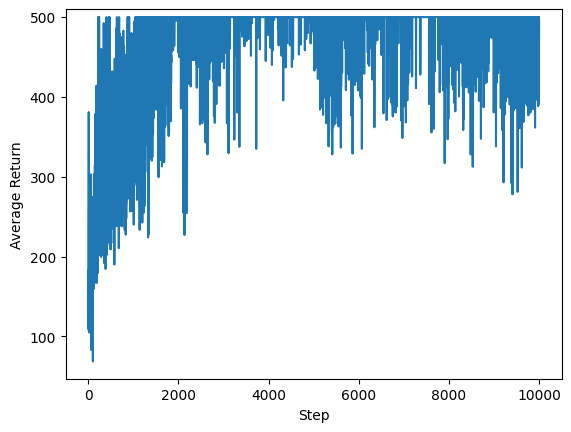

In [269]:
# steps = range(0, num_iterations + 1, int(num_iterations/len(returns)) )
steps = range(0, num_iterations , 2 )

# steps = range(0, num_iterations + 1, 10)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=max(returns) + 10)